# Analysis Processed Slocum Glider-AD2CP Data: RU29 2021 Mission 2

In [1]:
# Imports
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
import cmocean.cm as cmo
import sys

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
#sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
sys.path.insert(0,'../src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Step 1: Load glider data

In [65]:
ds_id = 'ru29-20210908T1943-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

gdf

# x=10
# plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])

,depth,latitude,longitude,time,sci_water_temp,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
0,0.0,18.172288,-64.968623,2021-09-08T19:43:16.84Z,0.0,0.0,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
1,NaN,18.172288,-64.968623,2021-09-08T19:43:22.01Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),0.0,0.0,1.77675
2,0.0,18.172288,-64.968623,2021-09-08T19:43:23.84Z,0.0,0.0,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
3,NaN,18.172288,-64.968623,2021-09-08T19:44:26.30Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),0.0,0.0,1.77675
4,NaN,18.172270,-64.968681,2021-09-08T19:44:52.37Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1453164,NaN,NaN,NaN,2021-10-07T19:57:17.47Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453165,NaN,NaN,NaN,2021-10-07T19:57:23.31Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453166,NaN,NaN,NaN,2021-10-07T19:57:30.35Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453167,NaN,NaN,NaN,2021-10-07T19:57:34.80Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN


## Step 2: Load processed AD2CP data

In [75]:
#path = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/Processed/"
path = "/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/RU_29/2021_Mission_2_Processed_Velocity_Profiles/"

files = np.sort(glob.glob(path+'*.csv'))

df = pd.concat(map(pd.read_csv, files))

df

,Unnamed: 0,inversion_u,inversion_v,inversion_depth,longitude,latitude,start_tm,end_tm
0,0,-1.969025,0.816346,2.5,-64.969415,18.170682,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z
1,1,-1.966424,0.816045,7.5,-64.969415,18.170682,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z
2,2,-1.957204,0.740344,12.5,-64.969415,18.170682,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z
3,3,-1.969123,0.748203,17.5,-64.969415,18.170682,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z
4,4,-1.997290,0.814834,22.5,-64.969415,18.170682,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z
...,...,...,...,...,...,...,...,...
159,159,-0.036732,0.071233,797.5,-63.237413,18.024178,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z
160,160,-0.037366,0.065377,802.5,-63.237413,18.024178,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z
161,161,-0.037921,0.065736,807.5,-63.237413,18.024178,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z
162,162,-0.037845,0.071177,812.5,-63.237413,18.024178,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z


In [76]:
inversion_depth   = np.arange(2.5,1030,5)
inversion_lat    = np.empty(len(files))
inversion_lat[:] = np.NaN
inversion_lon    = np.empty(len(files))
inversion_lon[:] = np.NaN
inversion_time    = np.empty(len(files))
inversion_time[:] = np.NaN
inversion_time = inversion_time.astype(pd.Timestamp)


u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file

for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    inversion_lat[x] = df.latitude.values[0]
    inversion_lon[x] = df.longitude.values[0]
    inversion_time[x] = pd.to_datetime(df.start_tm.values[0])

    
## Now stuff into an organized xarray dataset    
ds = xr.Dataset(
    data_vars=dict(
        u_grid    = (["depth", "time"], u_grid),
        v_grid    = (["depth", "time"], v_grid),
        latitude  = (["time"], inversion_lat),
        longitude = (["time"], inversion_lon)
    ),
    coords=dict(
        time  = pd.to_datetime(inversion_time).tz_localize(None).values,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU29 2020 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds = ds.sortby(ds.time)
ds

<xarray.Dataset>
Dimensions:    (depth: 206, time: 220)
Coordinates:
  * time       (time) datetime64[ns] 2021-09-08T19:43:16.840000 ... 2021-10-0...
  * depth      (depth) float64 2.5 7.5 12.5 ... 1.018e+03 1.022e+03 1.028e+03
Data variables:
    u_grid     (depth, time) float64 -1.969 -0.1918 -0.03012 ... nan nan nan
    v_grid     (depth, time) float64 0.8163 0.107 0.03424 ... nan nan nan
    latitude   (time) float64 18.17 18.17 18.15 18.12 ... 18.16 18.16 18.16 nan
    longitude  (time) float64 -64.97 -64.97 -64.97 -64.97 ... -64.81 -64.81 nan
Attributes:
    description:  Master/combined RU29 2020 AD2CP least-squares inversion vel...

/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


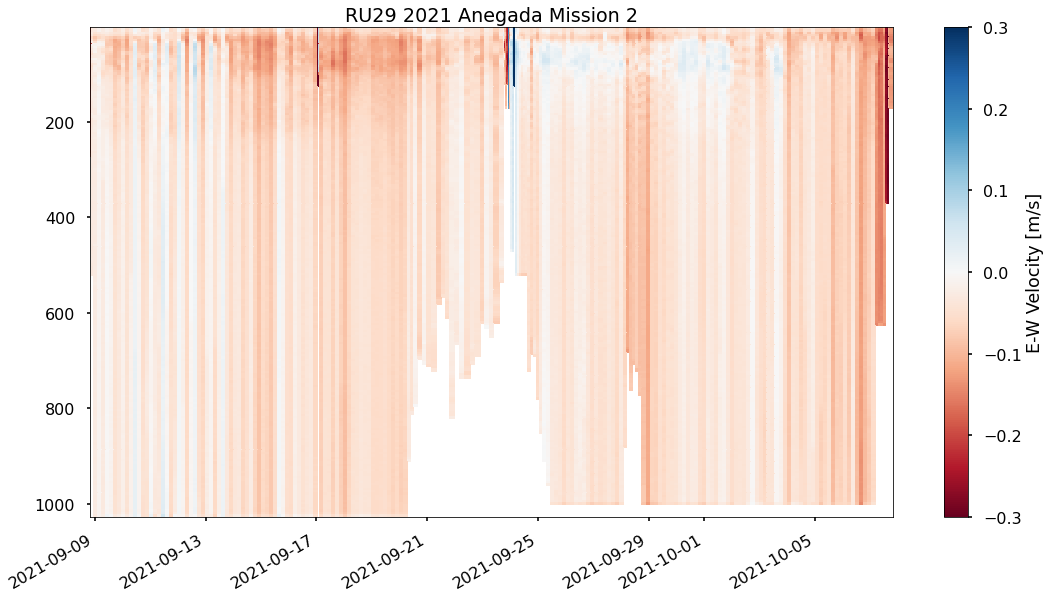

In [77]:
plt.figure(figsize=(18,10))
plt.pcolormesh(ds.time,ds.depth,ds.u_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]')
plt.title('RU29 2021 Anegada Mission 2')
plt.gcf().autofmt_xdate()

/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


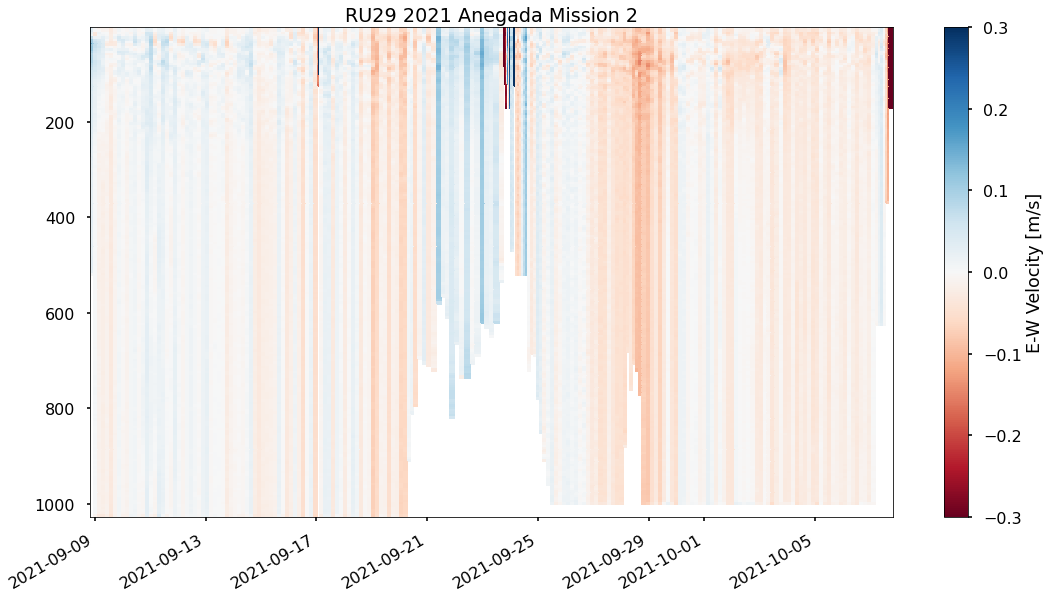

In [78]:
plt.figure(figsize=(18,10))
plt.pcolormesh(ds.time,ds.depth,ds.v_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]')
plt.title('RU29 2021 Anegada Mission 2')
plt.gcf().autofmt_xdate()

## Load 2021 mission #1 for plotting on same map

In [82]:
#path2 = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_1_AD2CP_NC/Processed/"
path2 = "/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/RU_29/2021_Mission_1_Processed_Velocity_Profiles/"

files2 = np.sort(glob.glob(path2+'*.csv'))

df2 = pd.concat(map(pd.read_csv, files2))

df2


,Unnamed: 0,inversion_u,inversion_v,inversion_depth,longitude,latitude,start_tm,end_tm
0,0,-0.175193,-0.016744,2.5,-64.831353,18.167903,2021-06-30T13:43:52Z,2021-06-30T14:30:55Z
1,1,-0.184418,-0.026048,7.5,-64.831353,18.167903,2021-06-30T13:43:52Z,2021-06-30T14:30:55Z
2,2,-0.187930,-0.044565,12.5,-64.831353,18.167903,2021-06-30T13:43:52Z,2021-06-30T14:30:55Z
3,3,-0.169074,-0.052273,17.5,-64.831353,18.167903,2021-06-30T13:43:52Z,2021-06-30T14:30:55Z
4,4,-0.223666,-0.016131,22.5,-64.831353,18.167903,2021-06-30T13:43:52Z,2021-06-30T14:30:55Z
...,...,...,...,...,...,...,...,...
145,145,-0.061261,-0.042370,727.5,-64.351057,18.387358,2021-07-04T06:46:35Z,2021-07-04T09:09:35Z
146,146,-0.061068,-0.043304,732.5,-64.351057,18.387358,2021-07-04T06:46:35Z,2021-07-04T09:09:35Z
147,147,-0.062422,-0.044048,737.5,-64.351057,18.387358,2021-07-04T06:46:35Z,2021-07-04T09:09:35Z
148,148,-0.053725,-0.041377,742.5,-64.351057,18.387358,2021-07-04T06:46:35Z,2021-07-04T09:09:35Z


In [83]:
inversion_depth2   = np.arange(2.5,1030,5)
inversion_lat2    = np.empty(len(files2))
inversion_lat2[:] = np.NaN
inversion_lon2    = np.empty(len(files2))
inversion_lon2[:] = np.NaN
inversion_time2    = np.empty(len(files2))
inversion_time2[:] = np.NaN
inversion_time2 = inversion_time2.astype(pd.Timestamp)


u_grid2 = np.empty((len(inversion_depth2),len(files2)))
u_grid2[:] = np.NaN
v_grid2 = np.empty((len(inversion_depth2),len(files2)))
v_grid2[:] = np.NaN


## Loop through by file, load in each file

for x in np.arange(0,len(files2)):
    
    df2 = pd.read_csv(files2[x])
    
    u_grid2[np.arange(0,len(df2.inversion_u.values)),x] = df2.inversion_u.values
    v_grid2[np.arange(0,len(df2.inversion_v.values)),x] = df2.inversion_v.values
    inversion_lat2[x] = df2.latitude.values[0]
    inversion_lon2[x] = df2.longitude.values[0]
    inversion_time2[x] = pd.to_datetime(df2.start_tm.values[0])

    
## Now stuff into an organized xarray dataset    
ds2 = xr.Dataset(
    data_vars=dict(
        u_grid    = (["depth", "time"], u_grid2),
        v_grid    = (["depth", "time"], v_grid2),
        latitude  = (["time"], inversion_lat2),
        longitude = (["time"], inversion_lon2)
    ),
    coords=dict(
        time  = pd.to_datetime(inversion_time2).tz_localize(None).values,
        depth = inversion_depth2
    ),
    #attrs=dict(description="Master/combined RU29 2020 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds2 = ds2.sortby(ds2.time)
ds2

<xarray.Dataset>
Dimensions:    (depth: 206, time: 112)
Coordinates:
  * time       (time) datetime64[ns] 2021-06-30T13:43:52 ... 2021-07-14T10:23:26
  * depth      (depth) float64 2.5 7.5 12.5 ... 1.018e+03 1.022e+03 1.028e+03
Data variables:
    u_grid     (depth, time) float64 -0.1752 0.0104 0.0007412 ... nan nan nan
    v_grid     (depth, time) float64 -0.01674 0.005627 -0.02594 ... nan nan nan
    latitude   (time) float64 18.17 18.16 18.15 18.14 ... 18.15 18.15 18.14
    longitude  (time) float64 -64.83 -64.82 -64.8 ... -63.82 -63.83 -63.83

In [84]:
ds

<xarray.Dataset>
Dimensions:    (depth: 206, time: 220)
Coordinates:
  * time       (time) datetime64[ns] 2021-09-08T19:43:16.840000 ... 2021-10-0...
  * depth      (depth) float64 2.5 7.5 12.5 ... 1.018e+03 1.022e+03 1.028e+03
Data variables:
    u_grid     (depth, time) float64 -1.969 -0.1918 -0.03012 ... nan nan nan
    v_grid     (depth, time) float64 0.8163 0.107 0.03424 ... nan nan nan
    latitude   (time) float64 18.17 18.17 18.15 18.12 ... 18.16 18.16 18.16 nan
    longitude  (time) float64 -64.97 -64.97 -64.97 -64.97 ... -64.81 -64.81 nan
Attributes:
    description:  Master/combined RU29 2020 AD2CP least-squares inversion vel...

## Make a map

/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


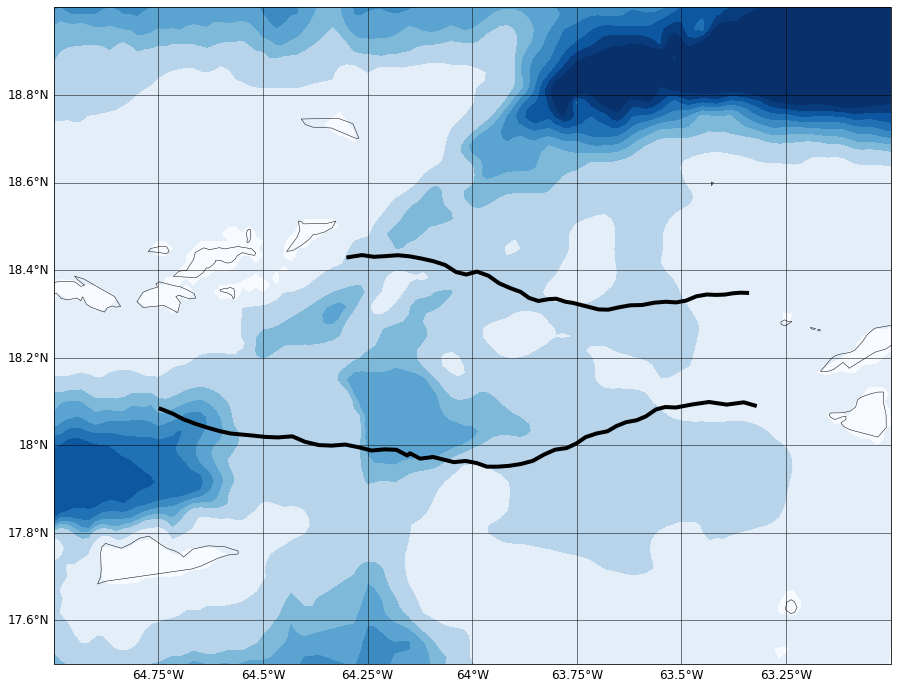

In [85]:
# grab bathymetry data for a map
import cartopy.crs as ccrs
lat_lims = [17.5, 19]
lon_lims = [-65, -63]

# grab some bathymetry
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'

etopo1 = xr.open_dataset(url).sel(lat = slice(lat_lims[0], lat_lims[1]), lon = slice(lon_lims[0], lon_lims[1] ))

fig = plt.figure(figsize=(15,20))
ax = plt.subplot( projection= ccrs.Mercator())

## Good but too smooth
#dpth_contours = np.arange(-8500, 1, 500)
dpth_contours = np.append(np.arange(-5000, -2000, 500), np.arange(-2000, 1, 1000)) 

subset_ds = ds.sel(time=slice("2021-09-14 00:00:00","2021-09-21 11:00:00"))
subset_ds2 = ds2.sel(time=slice("2021-07-04 12:00:00","2021-07-09 23:59:00"))

plt.plot(subset_ds.longitude, subset_ds.latitude,linewidth=4, transform=ccrs.PlateCarree(),color='black')
plt.plot(subset_ds2.longitude, subset_ds2.latitude,linewidth=4, transform=ccrs.PlateCarree(),color='black')

#plt.plot(gdf_sect.longitude.values, gdf_sect.latitude.values,linewidth=1, transform=ccrs.PlateCarree(),color='red')


plt.contourf(etopo1.lon, etopo1.lat, etopo1.topo, dpth_contours, transform=ccrs.PlateCarree(), cmap='Blues_r', zorder=0,extend='both')
#plt.colorbar(label='Depth [m]',pad=0.03, fraction=0.055)
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='black',linewidth=0.5)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

#plt.savefig('/Users/joegradone/Desktop/RU29_2021_Anegada_Map.png',dpi=300,facecolor='white')

## Anegada Subset

In [ ]:
subset_ds = ds.sel(time=slice("2021-09-14 00:00:00","2021-09-21 11:00:00"))

/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


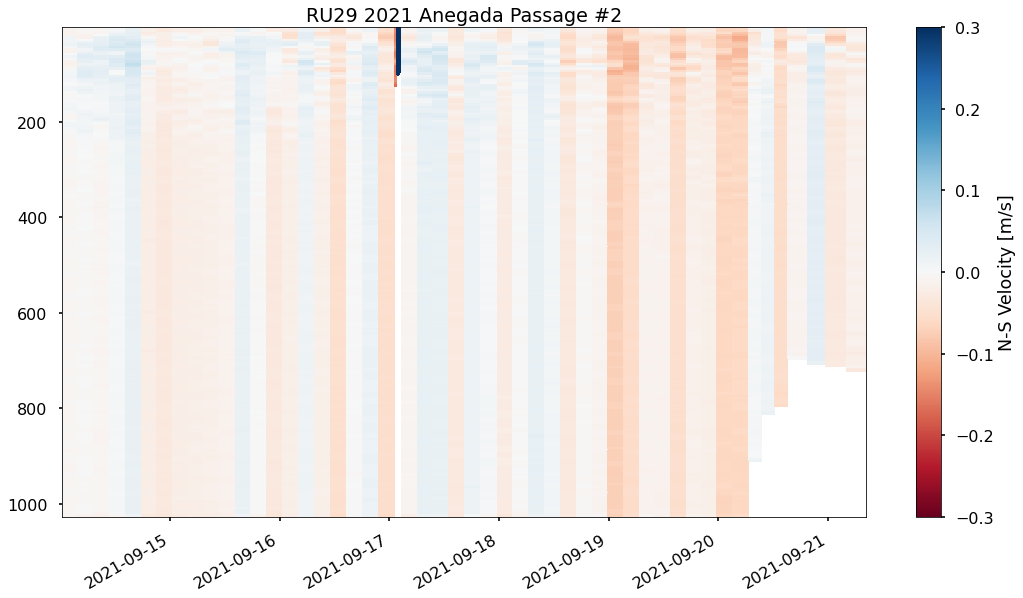

In [23]:
plt.figure(figsize=(18,10))
plt.pcolormesh(subset_ds.time,subset_ds.depth,subset_ds.v_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.gca().invert_yaxis()
plt.colorbar(label='N-S Velocity [m/s]')
plt.title('RU29 2021 Anegada Passage #2')
plt.gcf().autofmt_xdate()

/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


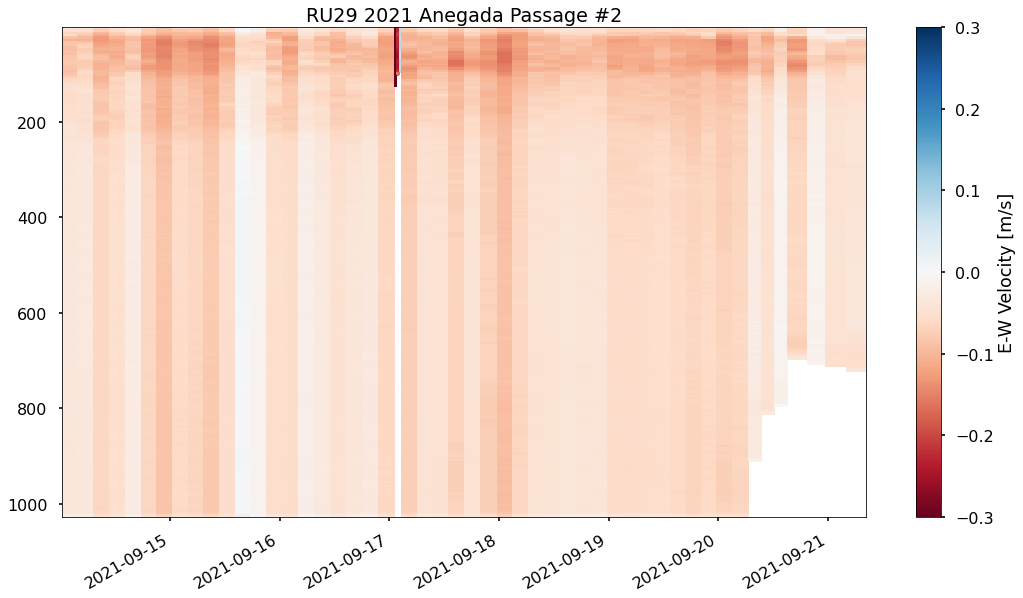

In [24]:
plt.figure(figsize=(18,10))
plt.pcolormesh(subset_ds.time,subset_ds.depth,subset_ds.u_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]')
plt.title('RU29 2021 Anegada Passage #2')
plt.gcf().autofmt_xdate()

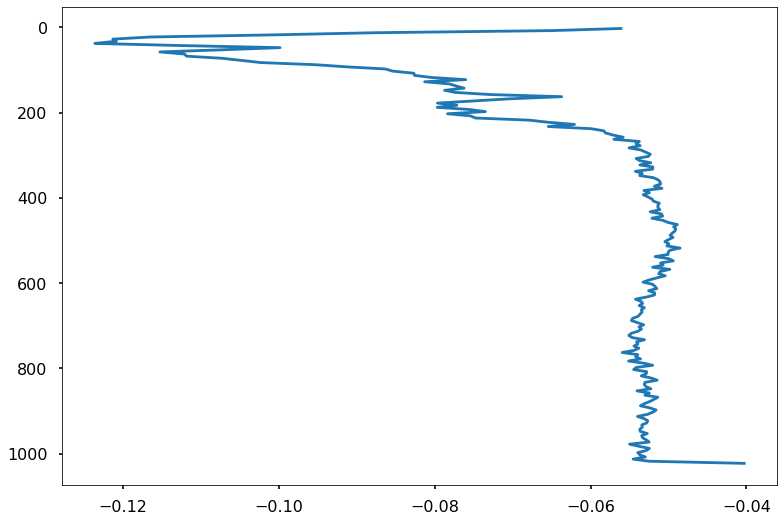

In [27]:
plt.plot(subset_ds.u_grid[:,10],subset_ds.depth)
plt.gca().invert_yaxis()

## What does "transport" look like through this section?

In [40]:
# from math import sin, cos, sqrt, atan2, radians

# def segment_dist(lat1,lon1,lat2,lon2):
#     # approximate radius of earth in km
#     R = 6373.0
    
#     ## Assuming it is in degrees first
#     lat1 = radians(lat1)
#     lon1 = radians(lon1)
#     lat2 = radians(lat2)
#     lon2 = radians(lon2)
    
#     dlon = lon2 - lon1
#     dlat = lat2 - lat1
    
#     a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
#     c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
#     distance = R * c *1000 # in meters
    
#     return(distance)


# seg_dist = np.empty(len(subet_ds.time))


In [51]:
distance = 3500 # m for a rough approximation before bringing in the true segment distance calculation

transport_u = (np.nansum(subset_ds.u_grid.values)*5*distance)/(10**6) # multiply by 5 because of grid cell size and distance must be the distance of one segment
transport_v = (np.nansum(subset_ds.v_grid.values)*5*distance)/(10**6) # multiply by 5 because of grid cell size


In [52]:
transport_v

-1.7176199003716355

In [53]:
transport_u

-10.26237377548591

## Testing rotating velocities by the orientation of the mouth of the Anegada Passage

In [54]:
along_vel = subset_ds.u_grid*np.cos(np.deg2rad(18))+subset_ds.v_grid*np.sin(np.deg2rad(18))
cross_vel = subset_ds.u_grid*np.sin(np.deg2rad(18))+subset_ds.v_grid*np.cos(np.deg2rad(18))
transport_along = (np.nansum(along_vel)*5*distance)/(10**6) # multiply by 5 because of grid cell size and distance must be the distance of one segment
transport_cross = (np.nansum(cross_vel)*5*distance)/(10**6) # multiply by 5 because of grid cell size

In [55]:
transport_along

-10.290871190923811

In [56]:
transport_cross

-4.804801498019614

In [70]:

# def grid_glider_data(df, varname, delta_z=.3):
#     """
#     Written by aristizabal. Returns a gridded glider dataset by depth and time
#     """
#     #df.dropna(inplace=True)
#     df.dropna() # Changed to work with ru29 2020 datatset by JG
#     df.drop(df[df['depth'] < .1].index, inplace=True)  # drop rows where depth is <1
#     df.drop(df[df[varname] == 0].index, inplace=True)  # drop rows where the variable equals zero
#     df.sort_values(by=['time', 'depth'], inplace=True)

#     # find unique times and coordinates
#     timeg, ind = np.unique(df.time.values, return_index=True)
#     latg = df['latitude'].values[ind]
#     long = df['longitude'].values[ind]
#     dg = df['depth'].values
#     vg = df[varname].values
#     zn = np.int(np.max(np.diff(np.hstack([ind, len(dg)]))))

#     depthg = np.empty((zn, len(timeg)))
#     depthg[:] = np.nan
#     varg = np.empty((zn, len(timeg)))
#     varg[:] = np.nan

#     for i, ii in enumerate(ind):
#         if i < len(timeg) - 1:
#             i_f = ind[i + 1]
#         else:
#             i_f = len(dg)
#         depthi = dg[ind[i]:i_f]
#         vari = vg[ind[i]:i_f]
#         depthg[0:len(dg[ind[i]:i_f]), i] = depthi
#         varg[0:len(vg[ind[i]:i_f]), i] = vari

#     # sort time variable
#     okt = np.argsort(timeg)
#     timegg = timeg[okt]
#     depthgg = depthg[:, okt]
#     vargg = varg[:, okt]

#     # Grid variables
#     depthg_gridded = np.arange(0, np.nanmax(depthgg), delta_z)
#     varg_gridded = np.empty((len(depthg_gridded), len(timegg)))
#     varg_gridded[:] = np.nan

#     for t, tt in enumerate(timegg):
#         depthu, oku = np.unique(depthgg[:, t], return_index=True)
#         varu = vargg[oku, t]
#         okdd = np.isfinite(depthu)
#         depthf = depthu[okdd]
#         varf = varu[okdd]
#         ok = np.asarray(np.isfinite(varf))
#         if np.sum(ok) < 3:
#             varg_gridded[:, t] = np.nan
#         else:
#             okd = np.logical_and(depthg_gridded >= np.min(depthf[ok]), depthg_gridded < np.max(depthf[ok]))
#             varg_gridded[okd, t] = np.interp(depthg_gridded[okd], depthf[ok], varf[ok])

#     return timegg, long, latg, depthg_gridded, varg_gridded


In [69]:
# gl_tm, gl_lon, gl_lat, gl_depth, gl_temp = grid_glider_data(gdf, 'sci_water_temp', 0.5)

In [68]:
# plt.rcParams.update({'font.size': 25})
# myFmt = mdates.DateFormatter('%Y/%m/%d')

# plt.figure(figsize=(27,10))
# plt.scatter(gl_tm,gl_depth,c=gl_temp,cmap=cmo.thermal)
# cbar = plt.colorbar(pad=0.01)
# cbar.set_label(label='Temperature (°C)',size=25)
# cbar.ax.tick_params(labelsize=20) 

# plt.ylabel('Depth (m)', fontsize = 25)
# plt.yticks(fontsize = 25)
# plt.xticks(fontsize = 25)
# plt.ylim(1010,0)
# plt.gca().xaxis.set_major_formatter(myFmt)
# plt.gcf().autofmt_xdate()
# #plt.xlim(pd.to_datetime(gl_tm2[63]),pd.to_datetime(gl_tm2[140]))
# #plt.savefig('/Users/joegradone/Desktop/RU29_2021_Anegada_Temperature_Subset.png',dpi=300)